In [28]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
from scipy.stats import zscore
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [29]:
# Importing Data
INPUT_PATH = "E:/Programming/MLMomeni/ML/files/بمب.xlsx"
df = pd.read_excel(INPUT_PATH)
df.columns = df.columns.map(lambda x: x.strip() if isinstance(x, str) else x) # To delete any spaces between
df.describe()

,Monetary,Frequency,Recency
count,793.000000,793.000000,793.000000
mean,14486.837417,6.316520,146.802018
std,15440.523708,2.550885,186.211051
min,10.449000,1.000000,0.000000
25%,4768.010000,5.000000,30.000000
50%,9974.654000,6.000000,75.000000
75%,18527.648000,8.000000,183.000000
max,146749.770000,17.000000,1165.000000


In [18]:
# Required Features for Clustering
FEATURES = [
    "Monetary", 
    "Frequency",
    "Recency"   
]

In [19]:
# Outlier Detection
Z_THRESH = 3.5
NUM_COLS_FOR_OUTLIER = ["Monetary"]
#Z-Score Calculation
z_df = pd.DataFrame(zscore(df[NUM_COLS_FOR_OUTLIER].astype(float)),
                    columns=NUM_COLS_FOR_OUTLIER, index=df.index)
z_df


is_outlier = (z_df.abs() > Z_THRESH).any(axis=1)
df["IsOutlier"] = is_outlier.astype(int)


df["IsOutlier"]

0      0
1      0
2      0
3      0
4      0
      ..
788    0
789    0
790    0
791    0
792    0
Name: IsOutlier, Length: 793, dtype: int32

In [20]:
# No Outliers DataFrame
no_out_df = df[df["IsOutlier"] == 0].dropna(subset=[c for c in FEATURES if c in df.columns]).copy()
no_out_df.describe()

,Monetary,Frequency,Recency,IsOutlier
count,783.000000,783.000000,783.000000,783.0
mean,13506.705375,6.296296,146.707535,0.0
std,12456.722074,2.538516,186.228581,0.0
min,10.449000,1.000000,0.000000,0.0
25%,4713.209000,5.000000,30.000000,0.0
50%,9801.506000,6.000000,76.000000,0.0
75%,18329.239000,8.000000,181.500000,0.0
max,66671.696000,17.000000,1165.000000,0.0


In [24]:
# Finding the best K value function
def choose_best_k(X):
    List = []
    kmeans_set = {'init': 'random', 'n_init':300, 'random_state':42}
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_set)
        kmeans.fit(X)
        List.append(kmeans.inertia_)
    k1 = KneeLocator(range(1, 11), List, curve='convex', direction='decreasing')
    best_k = k1.elbow
    # Plot
    plt.plot(range(1, 11), List)
    plt.xticks(range(1, 11))
    plt.xlabel('clusters')
    plt.ylabel('inertia')
    plt.axvline(x=k1.elbow, color='b', label='axvline', ls='--')
    plt.show()
    return best_k

In [22]:
# Model Function
def kmeans_cluster(dfx, features):
    kmeans_set = {'init': 'random', 'n_init':300, 'random_state':42}
    X = dfx[features].astype(float).values
    k = choose_best_k(X)
    km = KMeans(n_clusters=k, **kmeans_set)
    labels = km.fit_predict(X)
    dfx["Cluster"] = labels
    #Plot
    cluster_colors = {0: '#1f77b4',# Blue
                      1: '#ff7f0e',# Orange
                      2: '#2ca02c',# Green
                      3: '#d62728',# Red
                      4: '80080'}#Purple
    colors = dfx["Cluster"].map(cluster_colors)
    fig = plt.figure(figsize=(13, 13))
    ax = fig.add_subplot(projection='3d')
    scatter = ax.scatter(dfx["Monetary"], dfx["Frequency"],dfx["Recency"],c=colors,marker='o')
    ax.set_xlabel("Monetary")
    ax.set_ylabel("Frequency")
    ax.set_zlabel("Recency")
    ax.set_title('3D Scatter Plot Of Customer data by cluster')
    plt.show()
    return labels, k
    

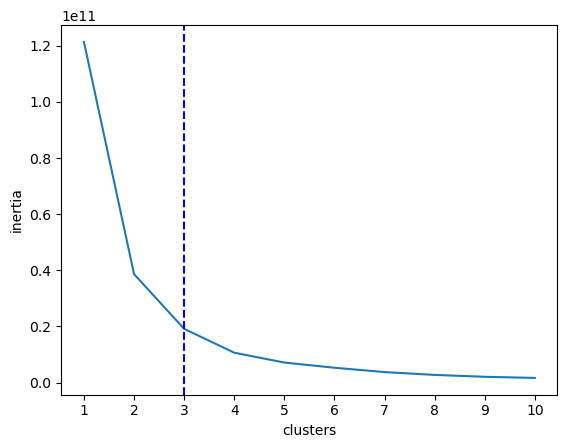

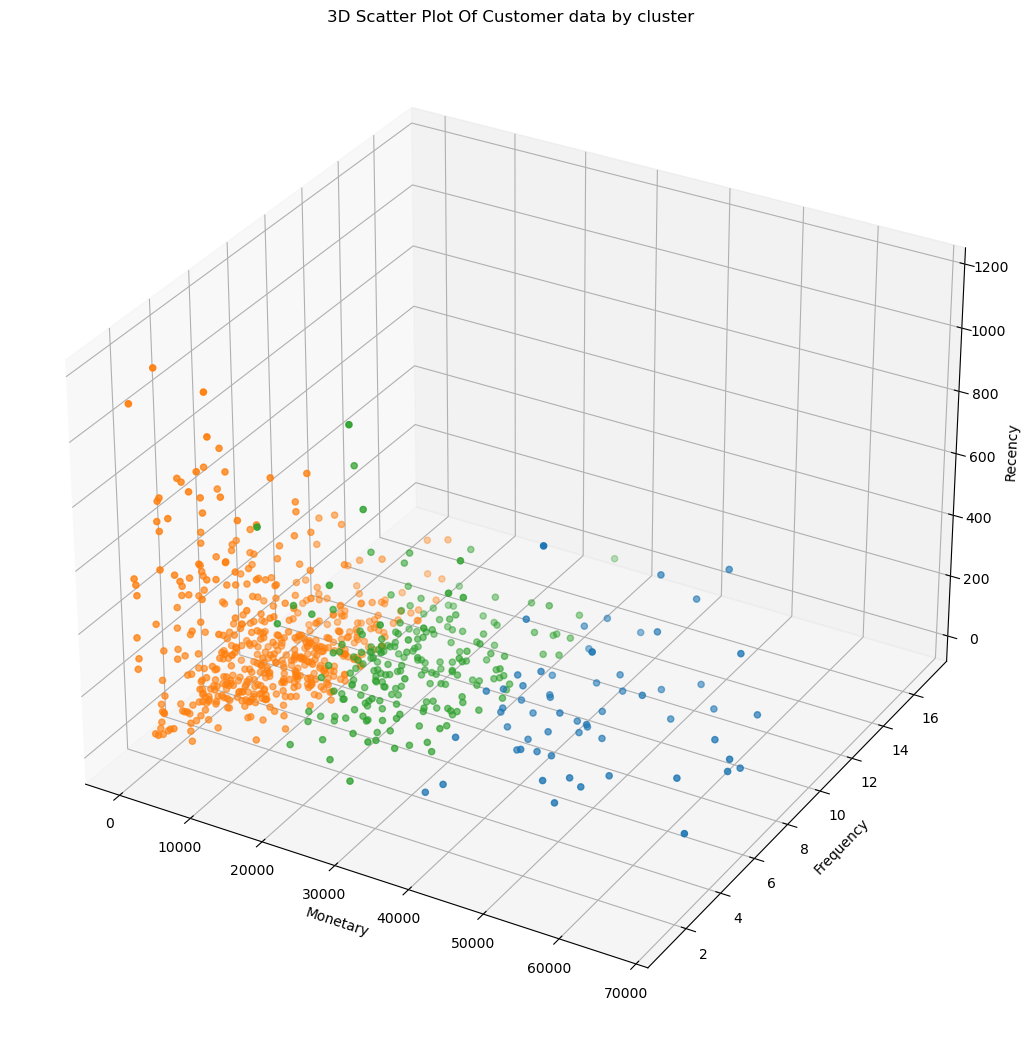

Best k = 3 | rows = 783


In [23]:
# Clustering
full_df = no_out_df.dropna(subset=[c for c in FEATURES if c in df.columns]).copy()
full_labels, full_k = kmeans_cluster(full_df, FEATURES)
print("Best k =", full_k, "| rows =", len(full_df))

<Figure size 1200x600 with 0 Axes>

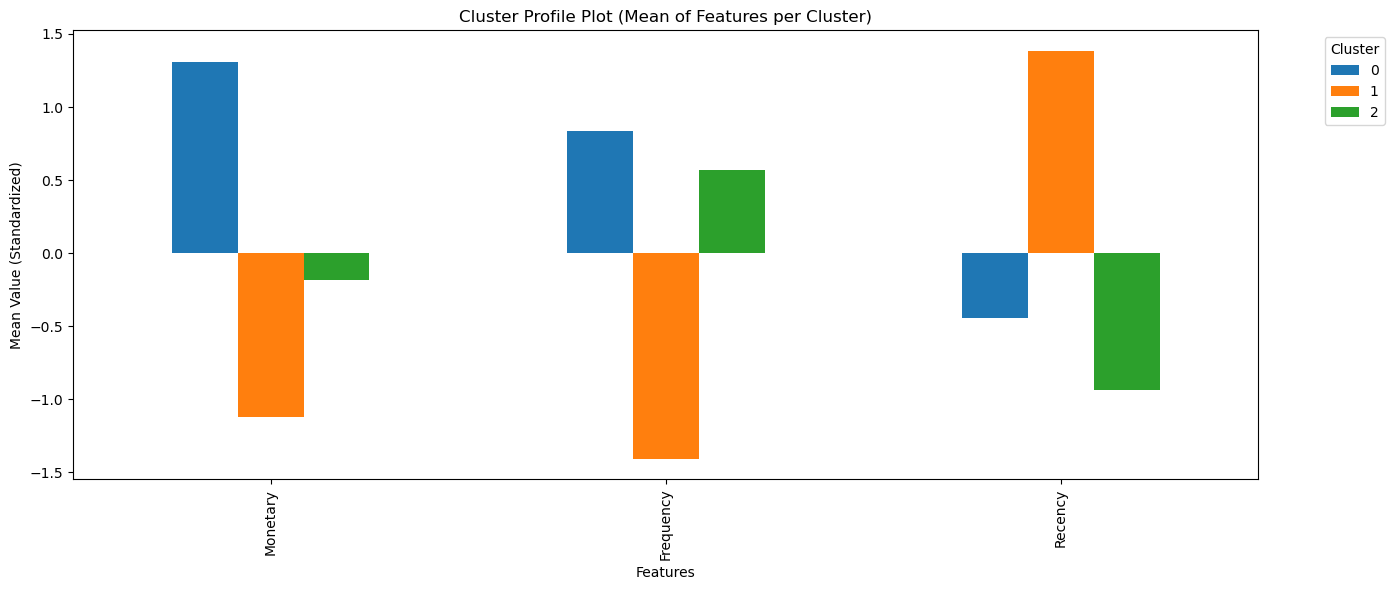

In [25]:
# Calculating the average of every feature
cluster_profile = full_df.drop(['Customer','IsOutlier'],axis=1)
cluster_profile = cluster_profile.groupby("Cluster").mean()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_profile)
df_2d_with_columns = pd.DataFrame(X_scaled, columns=['Monetary','Frequency' ,'Recency'])
# Box Profile Plot
plt.figure(figsize=(12, 6))
df_2d_with_columns.T.plot(kind='bar', figsize=(14, 6))
plt.title("Cluster Profile Plot (Mean of Features per Cluster)")
plt.ylabel("Mean Value (Standardized)")
plt.xlabel("Features")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [26]:
# Evaluation metrics
dfx = full_df[FEATURES].astype(float).values
sil_score = silhouette_score(dfx, full_labels)
db_index = davies_bouldin_score(dfx, full_labels)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies–Bouldin Index: {db_index:.3f}")

Silhouette Score: 0.610
Davies–Bouldin Index: 0.522


In [27]:
# Creating Outlier only dataframe
out_only_df = df[df["IsOutlier"] == 1].dropna(subset=[c for c in FEATURES if c in df.columns]).copy()

In [14]:
#Save final dataframe to an excel file
OUTPUT_XLSX = "ClusteringCustomer.xlsx"
with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl") as writer:
    full_df.to_excel(writer, index=False, sheet_name="NoOutlier")
    out_only_df.to_excel(writer, index=False, sheet_name="OutlierOnly")
print("Saved to", OUTPUT_XLSX)

Saved to ClusteringCustomer.xlsx
